In [10]:
import numpy as np
import pandas as pd
from mouselabdiscrete import NewMouselabEnv
from evaluation import *
from distributions import sample, expectation, Normal, Categorical, Mixture, PiecewiseUniform
import torch.nn as nn
import torch
from time import time

/home/amehta/virtualenvs/mouselab/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
import pickle

bins = [(-1, -0.8),
 (-0.8, -0.6),
 (-0.6, -0.4),
 (-0.4, -0.2),
 (-0.2, 0.0),
 (0.0, 0.2),
 (0.2, 0.4),
 (0.4, 0.6),
 (0.6, 0.8),
 (0.8, 1.0)]

stock_id = 0

stockfile = open("stock_dists.pkl", 'rb')
stock_dists = pickle.load(stockfile)

In [12]:
true_probs = stock_dists[sorted(stock_dists.keys())[stock_id]]

In [14]:
num_datapoints = 10000
num_epochs = 5000
num_episodes = 1000
num_test_episodes = 1000


In [15]:
gambles = 7
attributes = 4
scaledist = 100
scalecost = 200
#low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = PiecewiseUniform(bins, true_probs)*scaledist
testreward = reward
cost=0.01*scalecost

alpha = 0.15

max_action = (gambles + 1)*attributes + 1

In [16]:
rewardfilename = 'truerewards/bmps' + str(scalecost) + '_' + str(stock_id) + '.npy'
myopicfilename = 'truerewards/mvoc' + str(scalecost) + '_' + str(stock_id) + '.npy'

In [17]:
class BMPS_Approximator(nn.Module):
    def __init__(self, input_size, output_size):
        super(BMPS_Approximator, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.network = nn.Sequential(
                            nn.Linear(input_size, input_size//2),
                            nn.ReLU(),
                            nn.Linear(input_size // 2, input_size // 4),
                            nn.ReLU(),
                            nn.Linear(input_size // 4, input_size//8),
                            nn.ReLU(),
                            nn.Linear(input_size // 8, output_size)
                            )
    def forward(self, X):
        output = self.network(X)
        return output
    
    def train_epoch(self, train_X, train_Y, criterion, optimizer):
        output = self.forward(train_X)
        loss = criterion(output, train_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss

def train_model(model, train_X, train_Y, criterion, optimizer, num_epochs=num_epochs):
    for epoch_num in range(1, num_epochs+1):
        if epoch_num % 1000 == 0:
            print(f"Epoch {epoch_num}")
        loss = model.train_epoch(train_X, train_Y, criterion, optimizer)
        if epoch_num % 1000 == 0:
            print(loss.item())


In [18]:
def create_tensors(feature_df, vpi=False):
    X = []
    Y = []
    for index, data in feature_df.iterrows():
        #x = []
        y = []
        x = data['beliefstate']
        if not vpi:
            x = np.concatenate((x, data['one_hot_action']))
        for f in ['expected_term_reward', 'cost']:
            x = np.append(x, data[f])
        #for f in features:
        #    x.append(data[f])
        for f in ['myopic_voc', 'vpi', 'vpi_action']:
            y.append(data[f])
        X.append(x)
        Y.append(y)
    return torch.tensor(X, requires_grad=True), torch.tensor(Y, requires_grad=True)

In [19]:
def gen_data(num_points, seed = None):
    if seed is not None:
        np.random.seed(seed)
    for i in range(num_points):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha = alpha)
        
        #exclude terminal action while devising current state
        possible_actions = list(env.actions())[:-1]
        
        num_attributes = np.random.choice(attributes)
        num_actions = np.random.choice(attributes*gambles)
        
        attributes_taken = np.random.choice(possible_actions[:attributes], size = num_attributes, replace = False)
        actions_taken = np.random.choice(possible_actions[attributes:], size = num_actions, replace = False)

        actions_taken = np.concatenate((attributes_taken, actions_taken))
        
        for action in actions_taken:
            env._step(action)
        
        a = np.array(list(env.actions()))
        possible_actions = list(a[a < attributes])
        
        
        #possible_actions.append(env.term_action)
        
        action = np.random.choice(possible_actions)
        feats = env.action_features(action)
        
        state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
        
        #print(env.mus, env.vars)
        gamble_feats = env.mus
        
        yield (np.concatenate((env.dist, gamble_feats, state)), np.sort(actions_taken), action, *feats)


In [20]:
def get_one_hot_encoding(row):
    one_hot_action = np.zeros(max_action)
    one_hot_action[row.actions_taken] = 1
    one_hot_action[row.action] = 2
    return one_hot_action
    

In [21]:
t1 = time()

In [22]:
data = list(gen_data(num_datapoints))

In [23]:
df = pd.DataFrame(data, columns = ['beliefstate', 'actions_taken', 'action', 'cost','myopic_voc', 'vpi_action', 'vpi', 'expected_term_reward'])

In [24]:
df['one_hot_action'] = df.apply(get_one_hot_encoding, axis=1)

In [25]:
X, Y = create_tensors(df)

In [26]:
VPI_X, Y = create_tensors(df, vpi=True) # For VPI, we don't need the action vector

In [27]:
myopic_voc_approx = BMPS_Approximator(X.shape[-1], 1)
vpi_approx = BMPS_Approximator(VPI_X.shape[-1], 1)
vpi_action_approx = BMPS_Approximator(X.shape[-1], 1)

In [28]:
# Hyperparam
learning_rate = 1e-4

criterion = nn.MSELoss()
# Optimizers
mvoc_optimizer = torch.optim.Adam(myopic_voc_approx.parameters(), lr=learning_rate)
vpi_action_optimizer = torch.optim.Adam(vpi_action_approx.parameters(), lr=learning_rate)
vpi_optimizer = torch.optim.Adam(vpi_approx.parameters(), lr=learning_rate*10)

# Train the networks
train_model(vpi_approx, VPI_X.float(), Y[:, 1].unsqueeze_(1), criterion, vpi_optimizer)
train_model(vpi_action_approx, X.float(), Y[:, 2].unsqueeze_(1), criterion, vpi_action_optimizer)
train_model(myopic_voc_approx, X.float(), Y[:, 0].unsqueeze_(1), criterion, mvoc_optimizer)

#create_dir("voc_models")
torch.save(vpi_approx.state_dict(), "voc_models/vpibins.pth")
torch.save(vpi_action_approx.state_dict(), "voc_models/vpi_action_attributesbins.pth")
torch.save(myopic_voc_approx.state_dict(), "voc_models/myopic_voc_attributesbins.pth")


In [29]:
t2 = time()

In [30]:
t2 - t1

7.011803865432739

---

## Bayesian Optimization

In [31]:
import GPyOpt
import GPy

In [32]:
env_array = []

def make_train_envs(num_episodes = num_episodes):
    np.random.seed(1000)
    for i in range(num_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=alpha, sample_term_reward = True)
        env_array.append(env)

make_train_envs()        


def blackboxfunc(W):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
        
    cumreturn = 0
    
#    for i in range(num_episodes):
#        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=0.15)
    for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                env._reset()
                break
        
        cumreturn += exp_return
        #print(exp_return)
    
    print(cumreturn/num_episodes)
    return -cumreturn/num_episodes

In [33]:
#pbounds = {'w1': (0,1), 'w2': (0,1), 'w3': (0,1), 'w4':(1,12)}
space = [{'name': 'w1', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w2', 'type': 'continuous', 'domain': (0,1)},
         {'name': 'w4', 'type': 'continuous', 'domain': (0,1)}]

constraints = [{'name': 'part_1', 'constraint': 'x[:,0] + x[:,1] - 1'}]

feasible_region = GPyOpt.Design_space(space = space, constraints = constraints)

In [34]:
# --- CHOOSE the intial design
from numpy.random import seed # fixed seed
seed(123456)

initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 10)

In [35]:
# --- CHOOSE the objective
objective = GPyOpt.core.task.SingleObjective(blackboxfunc)

# --- CHOOSE the model type
#This model does Maximum likelihood estimation of the hyper-parameters.
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# --- CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# --- CHOOSE the type of acquisition
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)

# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [36]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

In [37]:
# --- Stop conditions
max_time  = 60000 
tolerance = 1e-4    # distance between two consecutive observations  

In [38]:
# Run the optimization  
bt1 = time()
max_iter  = 20
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=True) 
bt2 = time()

-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
-0.5165312985455275
num acquisition: 1, time elapsed: 0.73s


In [39]:
bo.x_opt

array([0.127, 0.373, 0.853])

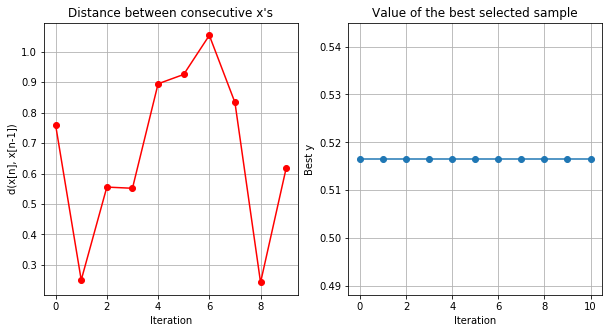

In [40]:
bo.plot_acquisition()
bo.plot_convergence()

In [41]:
bt2 - bt1

3.523876428604126

---

## Testing

In [42]:
optimal_weights = bo.x_opt
#optimal_weights = np.array([0.019, 0.91 , 3.511])

In [43]:
sample_term_reward = True

In [44]:
def testfunc(W):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
    
    cumreturn = 0
    
    np.random.seed(100)
    
    for i in range(num_test_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, ground_truth_dist = testreward, alpha=alpha, sample_term_reward = sample_term_reward)
    #for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                #env._reset()
                break
        
        cumreturn += exp_return
        #print(exp_return)
    
    print(cumreturn/num_test_episodes)
    return -cumreturn/num_test_episodes

In [45]:
#testfunc(np.array([optimal_weights]))

In [46]:
def testsamefunc(W):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
    
    cumreturn = 0
    
    np.random.seed(100)
    unopened = 0
    rewardlist = []
    for i in range(num_test_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=alpha, sample_term_reward = sample_term_reward)
    #for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                unopened += len(possible_actions) - 1 
                #env._reset()
                break
        
        cumreturn += exp_return
        rewardlist.append(exp_return)
        #print(exp_return)
    
    avgclicks = (gambles + 1)*attributes - unopened/num_test_episodes
    print(avgclicks)
    print(cumreturn/num_test_episodes)
    np.save(rewardfilename, rewardlist)
    return -cumreturn/num_test_episodes

In [47]:
testsamefunc(np.array([optimal_weights]))

0.0
2.789088503187691


-2.789088503187691

In [48]:
def observe_strategy(W, num_episodes = 5):
    
    #num_episodes = 5
    
    w1 = W[:,0]
    w2 = W[:,1]
    w3 = 1 - w1 - w2
    w4 = W[:,2]
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
            VPI_X = torch.Tensor([vpi_x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
            vpi_action = vpi_action_approx(X)[0].item()
            vpi = vpi_approx(VPI_X)[0].item()
        
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
        
        elif action < env.term_action:
            #features = env.action_features(action)
            #features[0] is cost(action)
            #features[1] is myopicVOC(action) [aka VOI]
            #features[2] is vpi_action [aka VPIsub; the value of perfect info of branch]
            #features[3] is vpi(beliefstate)
            #features[4] is expected term reward of current state
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            term_reward = env.expected_term_reward()
            vpi_x = np.append(vpi_x, [term_reward, env.cost])
            VPI_X = torch.Tensor([vpi_x])
            vpi = vpi_approx(VPI_X)[0].item()
            
            myopic_voc = env.myopic_voi(action)
            vpi_action = env.vpi_action(action//env.outcomes)
            
            return w1*myopic_voc + env.cost + w2*vpi + w3*vpi_action + w4*env.cost*(len(possible_actions) - 2)
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
    
    cumreturn = 0
    
    np.random.seed(100)
    unopened = 0
    rewardlist = []
    for i in range(num_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=alpha, sample_term_reward = sample_term_reward)
    #for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            print(action_taken)
            if done:
                unopened += len(possible_actions) - 1 
                print(env.ground_truth, env.dist)
                #env._reset()
                break
        
        cumreturn += exp_return
        rewardlist.append(exp_return)
        #print(exp_return)
    
    avgclicks = (gambles + 1)*attributes - unopened/num_episodes
    print(avgclicks)
    print(cumreturn/num_episodes)
    return -cumreturn/num_episodes

In [49]:
#observe_strategy(np.array([optimal_weights]))

# Myopic VOC

In [50]:
def testMyopicVOC():
    
    #num_episodes = 5
    
    def voc_estimate(action):
        if action < attributes:
            state = np.vectorize(lambda g: expectation(g), otypes = [float])(env._state[1])
            gamble_feats = env.mus
            vpi_x = np.concatenate((env.dist, gamble_feats, state))
        
            one_hot_action = np.zeros(max_action)
            one_hot_action[actions_taken] = 1
            one_hot_action[action] = 2
        
            term_reward = env.expected_term_reward()
            x = np.concatenate((vpi_x, one_hot_action))
            x = np.append(x, [term_reward, env.cost])
        
            X = torch.Tensor([x])
        
            myopic_voc = myopic_voc_approx(X)[0].item()
        
            return myopic_voc + env.cost
        
        elif action < env.term_action:
            myopic_voc = env.myopic_voi(action)
            
            return myopic_voc + env.cost
            
            #return w1*features[1] + w2*features[3] + w3*features[2] + w4*features[0]
        else:
            return 0
    
    cumreturn = 0
    
    np.random.seed(100)
    unopened = 0
    rewardlist = []
    for i in range(num_test_episodes):
        env = NewMouselabEnv(gambles, attributes, reward, cost, alpha=alpha, sample_term_reward = sample_term_reward)
    #for env in env_array:

        exp_return = 0
        actions_taken = []
        
        while True:
            possible_actions = list(env.actions())

            #take action that maximises estimated VOC
            action_taken = max(possible_actions, key = voc_estimate)

            _, rew, done, _=env._step(action_taken)
            
            exp_return+=rew
            actions_taken.append(action_taken)
            
            if done:
                unopened += len(possible_actions) - 1 
                #env._reset()
                break
        
        cumreturn += exp_return
        rewardlist.append(exp_return)
        #print(exp_return)
    
    avgclicks = (gambles + 1)*attributes - unopened/num_test_episodes
    print(avgclicks)
    print(cumreturn/num_test_episodes)
    np.save(myopicfilename, rewardlist)
    return -cumreturn/num_test_episodes

In [51]:
testMyopicVOC()

0.0
2.789088503187691


-2.789088503187691